## Fetch housing data

In [24]:
import pandas as pd
import numpy as np
import tarfile
import urllib.request
import os
import matplotlib.pyplot as plt

def load_housing_data():
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    
    ## Save the tar file 
    current_dir = os.getcwd()
    output_file = "\housing.tgz"
    output_path = current_dir + output_file
    urllib.request.urlretrieve(url, output_path)

    with tarfile.open(output_path) as housing_tar:
        housing_tar.extractall(path=current_dir)

    os.chdir(current_dir + "/housing/")
    data = pd.read_csv("housing.csv", header=0)
    return(data)
    
housing = load_housing_data()

## Describe data

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

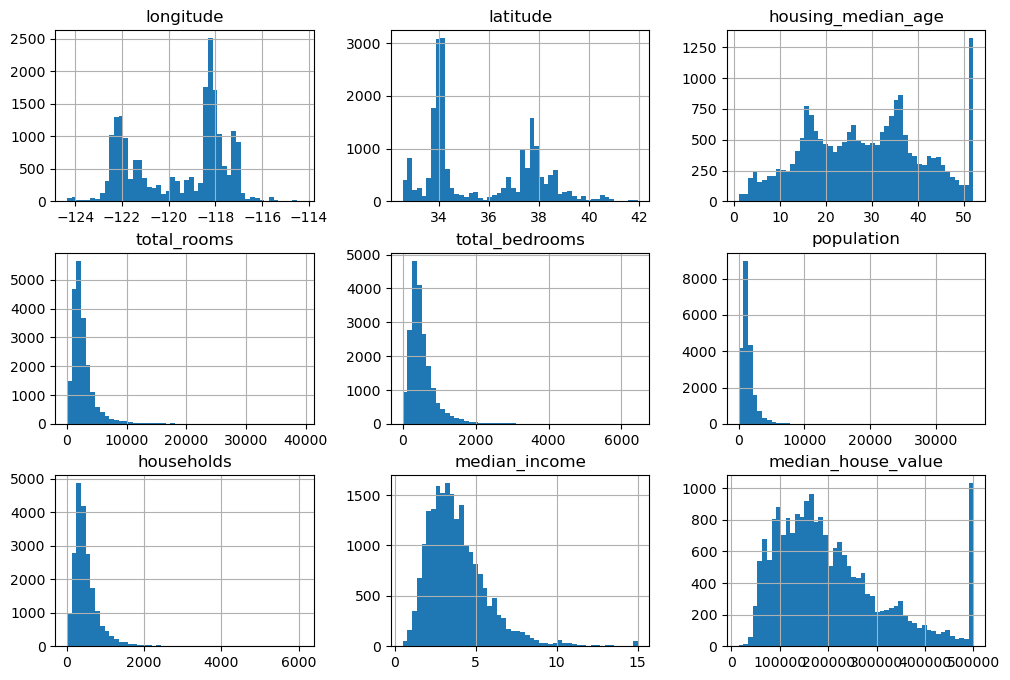

In [25]:
print(housing.head())
print(housing.info())
print(housing["ocean_proximity"].value_counts())
print(housing.describe())
housing.hist(bins=50, figsize=(12,8))
plt.show()

## Split data into train-test

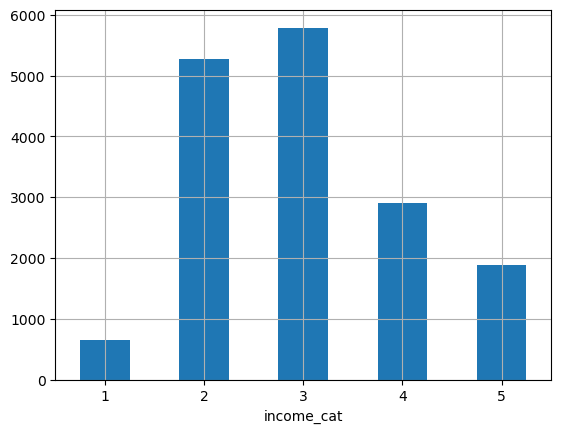

In [42]:
## Convert median income to income categories 1,2,3,4,5
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0, 1.5, 3, 4.5, 6, np.inf], labels = [1,2,3,4,5])

from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])
strat_train_set["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.show()

## Visualize data

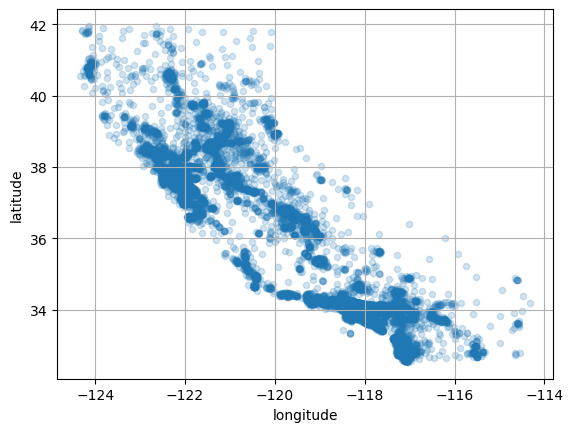

In [44]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

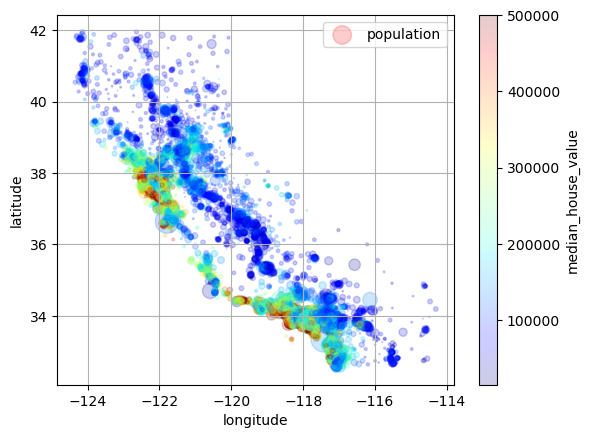

In [46]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"]/100, label="population", 
            c="median_house_value", cmap="jet", colorbar=True, legend=True, alpha=0.2)
plt.show()

## Plot scatter matrix

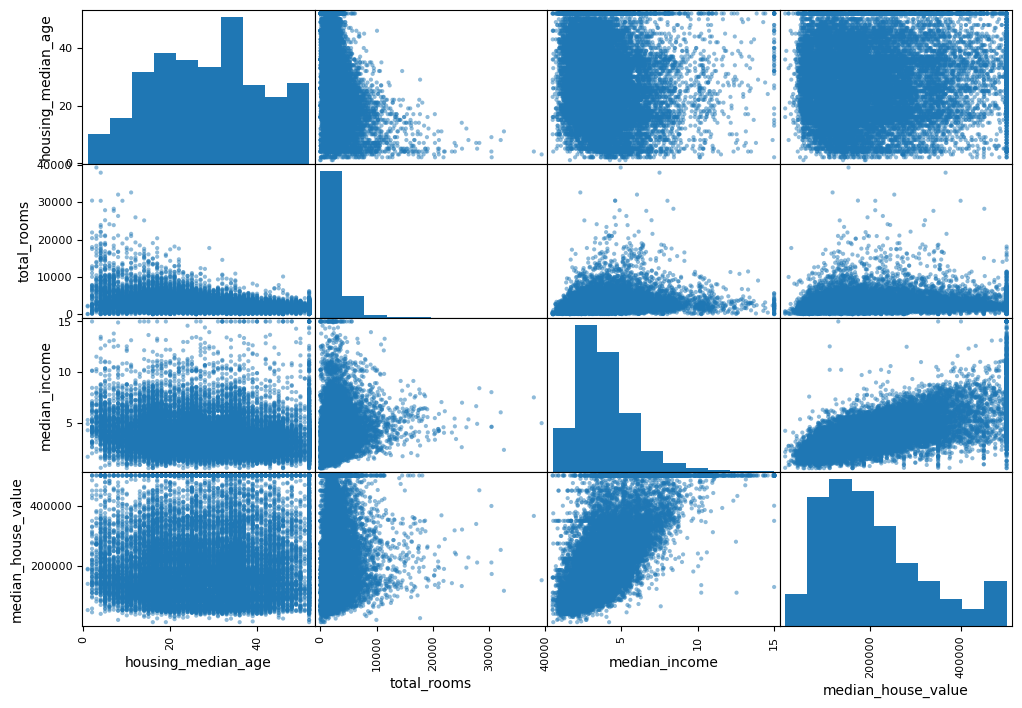

In [53]:
from pandas.plotting import scatter_matrix

attributes = ['housing_median_age', 'total_rooms', 'median_income', 'median_house_value']
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

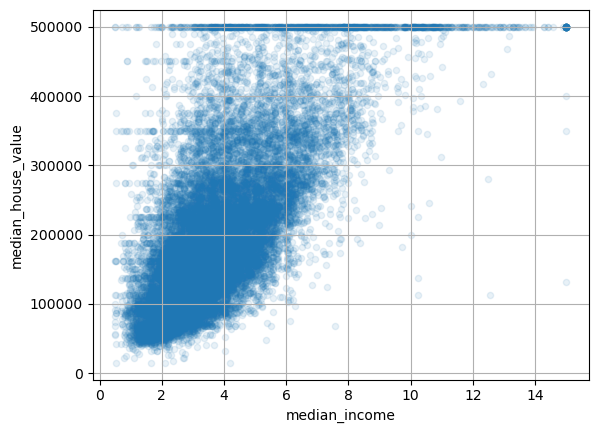

In [54]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
plt.show()

In [55]:
print(housing.columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')


In [56]:
## Create new attributes

housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_house"] = housing["population"]/housing["households"]

In [59]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
rooms_per_house       0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
people_per_house     -0.023737
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bedrooms_ratio       -0.255880
Name: median_house_value, dtype: float64

In [60]:
## Separate predictors and response

housing = strat_train_set.drop("median_house_value", axis=1)
housing_lables = strat_train_set["median_house_value"]

In [79]:
## Better way to impute
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

housing_num = housing.select_dtypes(include=[np.number])
X = pd.DataFrame(imputer.fit_transform(housing_num), columns=housing_num.columns, index=housing_num.index)

## One-hot encode the categorical features
from sklearn.preprocessing import OneHotEncoder

housing_cat = housing[["ocean_proximity"]]
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
print(housing_cat_1hot.toarray())
print(cat_encoder.categories_)

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_lables.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
print(predictions)

[[131997.15275877]
 [299359.35844434]
 [146023.37185694]
 [138840.33653057]
 [192016.61557639]]
